## Hypertune timegan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from models.data_generating_models.time_gan import TimeGAN
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging
from config import data_generation_config
import wandb

## Load data

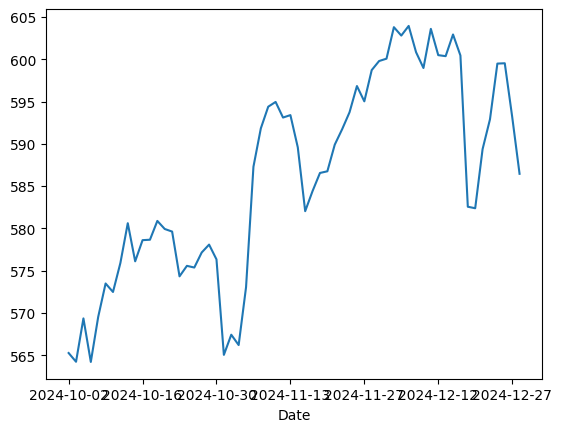

In [2]:
train_data = pd.read_csv("../data/raw/spy_daily_closing_prices_train.csv", index_col=0)

val_data = pd.read_csv("../data/raw/spy_daily_closing_prices_val.csv", index_col=0)

val_data = val_data["Close"]
val_data.plot(use_index=True)
val_data = np.array([val_data.values[i:i+30] for i in range(len(val_data)-30 + 1)])
val_data = pd.DataFrame(val_data)
val_data = val_data.div(val_data.iloc[:, 0], axis=0)

test_data = pd.read_csv("../data/raw/spy_daily_closing_prices_test.csv", index_col=0)
test_data = test_data["Close"]
test_data = np.array([test_data.values[i:i+30] for i in range(len(test_data)-30 + 1)])
test_data = pd.DataFrame(test_data)
test_data = test_data.div(test_data.iloc[:, 0], axis=0)

In [ ]:
wandb.login(key="52ea61320bbc9ee2b773e909700366e65977cd0f")

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'noise_scale': {
            'distribution': 'uniform',
            'min': 0.01,
            'max': 0.15
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.001,
            'max': 0.1
        },
        'hidden_size': {
            'values': [4, 8, 16, 32]
        },
    }
}

time_gan_config = {
    "data_name": "master",
    "module": "gru",
    "hidden_dim": 24,
    "num_layer": 3,
    "iterations": 10000,
    "batch_size": 128,
    "seq_len": 24,
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="time_gan_hyperopt")
# sweep_id = ""

In [3]:
def objective(config):
    hyperparameters = {
            "data_name": "master",
            "module": "gru",
            "hidden_dim": config.hidden_dim,
            "num_layer": config.num_layer,
            "iterations": 10000,
            "batch_size": 128,
            "seq_len": 24,
        }
    
    model = TimeGAN(train_data=train_data, N=data_generation_config["N"], M=data_generation_config["M"], load_params=False, config=hyperparameters)
    
    print("Fitting params to data")
    model.fit_params_to_data()
    print("Generating data")
    model.generate_data()

    df_post_processed = post_processing(model.synth_data, **post_processing_config)

    print('Hedging')
    val_loss = hedging(df_post_processed, val_data)

    return val_loss

def main():
    wandb.init()
    val_loss = objective(wandb.config)
    wandb.log({"val_loss": val_loss,  "loss": val_loss})

In [ ]:
wandb.agent(sweep_id, function=main, count=10, project="time_gan_hyperopt")

## Testing and plotting

In [3]:
hyperparameters = {
            "data_name": "master",
            "module": "gru",
            "hidden_dim": 16,
            "num_layer": 3,
            "iterations": 1000, # 10000,
            "batch_size": 128,
            "seq_len": 30,
        }
    
model = TimeGAN(train_data=train_data, N=data_generation_config["N"], M=data_generation_config["M"], load_params=False, config=hyperparameters)

print("Fitting params to data")
model.generate_data()
print("Generating data")
# model.generate_data()

df_post_processed = post_processing(model.synth_data, **post_processing_config)


# print('Hedging')
# val_loss = hedging(df_post_processed, val_data)

Fitting params to data
(1059, 30, 1)


2025-04-24 09:37:45.769931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


step: 0/1000, e_loss: 0.2266
step: 0/1000, s_loss: 0.106
step: 0/1000, d_loss: 2.178, g_loss_u: 0.7931, g_loss_s: 0.0107, g_loss_v: 0.2911, e_loss_t0: 0.0988


2025-04-24 09:43:46.470034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: FAILED_PRECONDITION: Could not find variable generator/dense_2/bias. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/generator/dense_2/bias)
	 [[{{node generator/dense_2_1/BiasAdd/ReadVariableOp}}]]


FailedPreconditionError: Graph execution error:

Detected at node 'generator/dense_2_1/BiasAdd/ReadVariableOp' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
    File "/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
    File "/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_15316/1667106282.py", line 14, in <module>
    File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/time_gan.py", line 26, in generate_data
    File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/TimeGAN/timegan1.py", line 243, in train_and_generate
    File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/TimeGAN/timegan1.py", line 40, in generator
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py", line 146, in call
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 237, in add
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/sparse.py", line 493, in sparse_wrapper
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 129, in add
    File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/core.py", line 80, in __tf_tensor__
Node: 'generator/dense_2_1/BiasAdd/ReadVariableOp'
Could not find variable generator/dense_2/bias. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/generator/dense_2/bias)
	 [[{{node generator/dense_2_1/BiasAdd/ReadVariableOp}}]]

Original stack trace for 'generator/dense_2_1/BiasAdd/ReadVariableOp':
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
  File "/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
  File "/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/3t/5vvh8l5x48s7tyvbx4b6v9xr0000gn/T/ipykernel_15316/1667106282.py", line 14, in <module>
  File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/time_gan.py", line 26, in generate_data
  File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/TimeGAN/timegan1.py", line 243, in train_and_generate
  File "/Users/sondrerogde/Dev/master-thesis/notebooks/../src/models/data_generating_models/TimeGAN/timegan1.py", line 40, in generator
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 909, in __call__
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 52, in __call__
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py", line 146, in call
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 237, in add
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/sparse.py", line 493, in sparse_wrapper
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 129, in add
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/ops/nn_ops.py", line 3558, in bias_add
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py", line 713, in convert_to_tensor
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/framework/tensor_conversion_registry.py", line 209, in convert
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/core.py", line 80, in __tf_tensor__
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/framework/tensor_conversion.py", line 161, in convert_to_tensor_v2_with_dispatch
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/framework/tensor_conversion.py", line 171, in convert_to_tensor_v2
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/framework/tensor_conversion_registry.py", line 234, in convert
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 2331, in _dense_var_to_tensor
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1577, in _dense_var_to_tensor
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 629, in value
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 813, in _read_variable_op
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 803, in read_and_set_handle
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 548, in read_variable_op
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py", line 2682, in _create_op_internal
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py", line 1177, in from_node_def


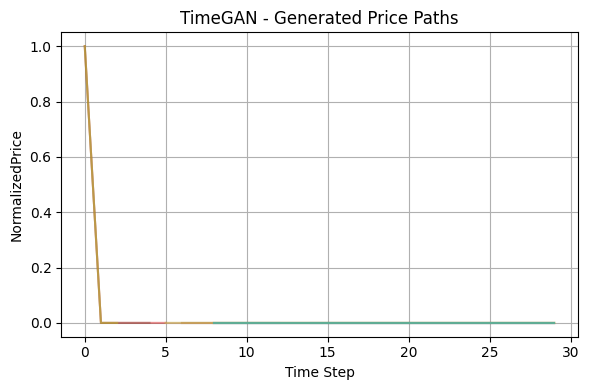

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot post-processed paths
for i in range(10):
    axs.plot(df_post_processed.iloc[i, :], alpha=0.5)


axs.set_title('TimeGAN - Generated Price Paths')
axs.set_xlabel('Time Step')
axs.set_ylabel('NormalizedPrice')
axs.grid(True)

plt.tight_layout()
plt.show()

In [7]:
from visualisation import visualization

train_data_vis = np.array(train_data[["Close"]].values)
train_data_vis = np.array([train_data_vis[i:i+30] for i in range(len(train_data_vis)-30 + 1)])
train_data_vis = train_data_vis / train_data_vis[:, 0:1]

df_post_processed_vis = np.array(df_post_processed.values)
df_post_processed_vis = df_post_processed_vis[..., np.newaxis]

print(train_data_vis.shape)
print(df_post_processed_vis.shape)

# visualization(ori_data=train_data_vis, generated_data=df_post_processed_vis, analysis='tsen', data_generating_model="TimeGAN", compare=train_data_vis.shape[0])
visualization(ori_data=train_data_vis, generated_data=df_post_processed_vis, analysis='tsne', data_generating_model="TimeGAN", compare=1000)

(1060, 30, 1)
(1059, 30, 1)


/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ValueError: Input X contains infinity or a value too large for dtype('float64').